# BYTD Model

## Assumption: 
* Purchase Behavior: poisson 
* Purchase Rate distribution:gamma
* Dropout Rate: geometric 
* Dropout Distribution: Beta distributon



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data,summary_data_from_transaction_data,calculate_alive_path
from lifetimes.plotting import plot_frequency_recency_matrix,plot_probability_alive_matrix,plot_period_transactions,plot_history_alive,plot_cumulative_transactions,plot_calibration_purchases_vs_holdout_purchases,plot_transaction_rate_heterogeneity,plot_dropout_rate_heterogeneity


In [6]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.0f}'.format

In [30]:
df0 = pd.read_csv("online_retail_10_11.csv")


In [31]:
df0.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [37]:
country = df0.groupby(['Country'])['Quantity'].sum().reset_index()
by_country = country.sort_values(by=['Quantity'], ascending=False)
by_country

,Country,Quantity
36,United Kingdom,4263829
24,Netherlands,200128
10,EIRE,142637
14,Germany,117448
13,France,110481
0,Australia,83653
32,Sweden,35637
33,Switzerland,30325
31,Spain,26824
20,Japan,25218


In [15]:
df0[df0.isnull().any(axis=1)]
#axis = 1, by row.
#within rows how may are null value
# remove records where customerID equal null, given we care about the customer with repeat buying behavior

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,3,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,3,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,1,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,2,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,5,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,11,NaN,United Kingdom


In [16]:
df1 = df0.copy()
df1 = df1[pd.notnull(df1["CustomerID"])]

In [17]:
df1.describe() 

,Quantity,UnitPrice,CustomerID
count,"406,830","406,830","406,830"
mean,12,3,"15,288"
std,249,69,"1,714"
min,"-80,995",0,"12,346"
25%,2,1,"13,953"
50%,5,2,"15,152"
75%,12,4,"16,791"
max,"80,995","38,970","18,287"


In [19]:
# remove return 
df1 = df1[df1['Quantity']>0]

In [20]:
df1.describe()

,Quantity,UnitPrice,CustomerID
count,"397,925","397,925","397,925"
mean,13,3,"15,294"
std,180,22,"1,713"
min,1,0,"12,346"
25%,2,1,"13,969"
50%,6,2,"15,159"
75%,12,4,"16,795"
max,"80,995","8,143","18,287"


In [21]:
# datetime to date format
df1["InvoiceDate"] = pd.to_datetime(df1["InvoiceDate"]).dt.date #normalize()
#df1.set_index("InvoiceDate", inplace=False)

# treat CustomerID as a categorical variable
df1["CustomerID"] = df1["CustomerID"].astype(np.int64).astype(object)

# review the categorical variables
df1.describe(include='object').T

,count,unique,top,freq
InvoiceNo,397925,18536,576339,542
StockCode,397925,3665,85123A,2035
Description,397925,3877,WHITE HANGING HEART T-LIGHT HOLDER,2028
InvoiceDate,397925,305,2011-11-06,3423
CustomerID,397925,4339,17841,7847
Country,397925,37,United Kingdom,354345


In [22]:
df1.describe()

,Quantity,UnitPrice
count,"397,925","397,925"
mean,13,3
std,180,22
min,1,0
25%,2,1
50%,6,2
75%,12,4
max,"80,995","8,143"


In [23]:
df1['Revenue'] = df1['Quantity']*df1['UnitPrice']


In [24]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Revenue'],
      dtype='object')

In [25]:
try:
    d1 = df1.drop(["InvoiceNo", "StockCode", "Description", "Country"], axis=1, inplace=True)
except:
    pass
df1.describe(include='object').T

,count,unique,top,freq
InvoiceDate,397925,305,2011-11-06,3423
CustomerID,397925,4339,17841,7847


In [26]:
df1.columns

Index(['Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Revenue'], dtype='object')

In [45]:
df1.rename({'Revenue': 'Revenues'}, axis=1,inplace=True)

In [39]:
# under staning date range, 373 days in total
print(df1['InvoiceDate'].min())
print(df1['InvoiceDate'].max())
print((df1['InvoiceDate'].max() - df1['InvoiceDate'].min()))

2010-12-01
2011-12-09
373 days, 0:00:00


In [46]:
df1.columns

Index(['Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Revenues'], dtype='object')

In [47]:
t_holdout = 240                                         # days to reserve for holdout period

max_date = df1["InvoiceDate"].max()                     # end date of observations
print("end of observations:", max_date)

max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period
print("end of calibration period:", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = df1, 
        customer_id_col = "CustomerID", 
        datetime_col = "InvoiceDate",
        monetary_value_col = "Revenues", 
        calibration_period_end = max_cal_date, 
        observation_period_end = max_date, 
        freq = "D")  

print("customer behavior in calibration and holdout periods")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

end of observations: 2011-12-09
end of calibration period: 2011-04-13
customer behavior in calibration and holdout periods


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0,0,85,0,0,0,240
12347,2,121,127,556,4,25,240
12348,2,110,118,297,1,103,240
12350,0,0,70,0,0,0,240
12352,3,34,56,422,3,20,240
...,...,...,...,...,...,...,...
18270,0,0,26,0,1,29,240
18272,0,0,6,0,5,18,240
18273,0,0,17,0,2,76,240


In [48]:
df_ch

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0,0,85,0,0,0,240
12347,2,121,127,556,4,25,240
12348,2,110,118,297,1,103,240
12350,0,0,70,0,0,0,240
12352,3,34,56,422,3,20,240
...,...,...,...,...,...,...,...
18270,0,0,26,0,1,29,240
18272,0,0,6,0,5,18,240
18273,0,0,17,0,2,76,240


In [49]:
df_ch.describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,"2,299","2,299","2,299","2,299","2,299","2,299","2,299"
mean,1,31,79,176,3,28,240
std,2,44,43,438,5,113,0
min,0,0,0,0,0,0,240
25%,0,0,42,0,1,3,240
50%,0,0,82,0,2,16,240
75%,1,65,124,252,4,23,240
max,35,133,133,"8,030",96,"4,307",240


Text(0.5, 1.0, 'customer age T (days): distribution of the customers')

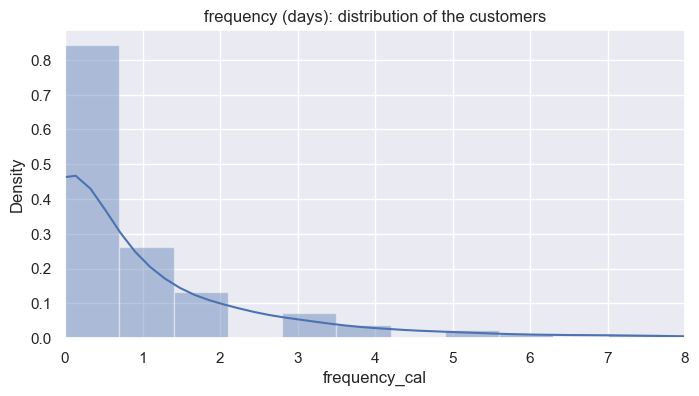

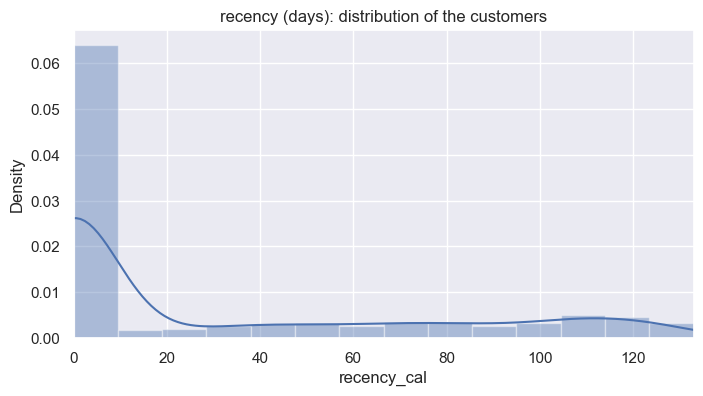

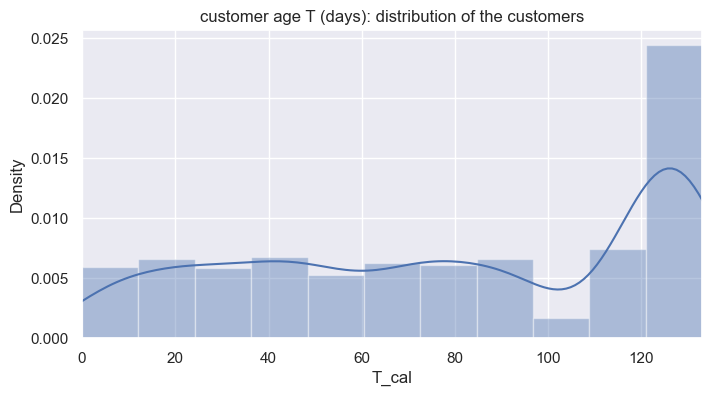

In [50]:
# training: axis length
max_freq = df_ch["frequency_cal"].quantile(0.98)
max_rec = df_ch["recency_cal"].max()
max_T = df_ch["T_cal"].max()


# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["frequency_cal"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers");


# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["recency_cal"])
ax.set_xlim(0, max_rec)
ax.set_title("recency (days): distribution of the customers")


# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["T_cal"])
ax.set_xlim(0, max_T)
ax.set_title("customer age T (days): distribution of the customers")

In [51]:
# training: BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)

Optimization terminated successfully.
         Current function value: 0.079518
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50


<lifetimes.BetaGeoFitter: fitted with 2299 subjects, a: 0.00, alpha: 54.76, b: 0.03, r: 0.69>

In [53]:
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.688,0.043,0.603,0.772
alpha,54.756,3.739,47.428,62.084
a,0.000,0.000,-0.000,0.000
b,0.034,10.428,-20.405,20.473


In [62]:
df_ch.groupby('CustomerID')['monetary_value_cal'].mean().mean()


175.89937119647124

<Figure size 1200x1200 with 0 Axes>

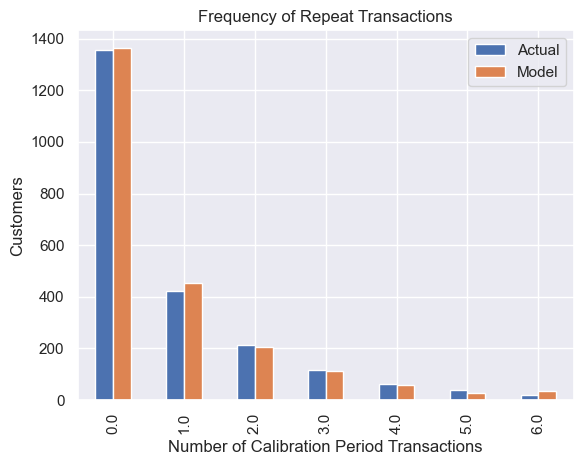

In [63]:
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);
# the number of transcation 0 is the most, the one with trancation > 6.0 has already been a legend.

In [64]:
df_ch.describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,"2,299.000","2,299.000","2,299.000","2,299.000","2,299.000","2,299.000","2,299.000"
mean,1.104,30.866,79.324,175.899,3.399,27.937,240.000
std,2.493,43.810,43.267,438.188,5.474,112.959,0.000
min,0.000,0.000,0.000,0.000,0.000,0.000,240.000
25%,0.000,0.000,42.000,0.000,1.000,3.458,240.000
50%,0.000,0.000,82.000,0.000,2.000,15.744,240.000
75%,1.000,65.000,124.000,252.215,4.000,23.092,240.000
max,35.000,133.000,133.000,"8,030.175",96.000,"4,307.180",240.000


In [78]:
df_rft = summary_data_from_transaction_data(
    transactions = df1, 
    customer_id_col = "CustomerID", 
    datetime_col = "InvoiceDate", 
    monetary_value_col = "Revenues", 
    observation_period_end = max_date, 
    freq = "D")

pd.options.display.float_format = '{:,.0f}'.format
df_rft

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0,0,325,0
12347,6,365,367,600
12348,3,283,358,301
12349,0,0,18,0
12350,0,0,310,0
...,...,...,...,...
18280,0,0,277,0
18281,0,0,180,0
18282,1,119,126,78


In [66]:
# BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -2.709794
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.827,0.027,0.774,0.879
alpha,68.910,2.618,63.779,74.041
a,0.002,0.006,-0.010,0.014
b,2.967,6.267,-9.317,15.250


131


<Figure size 1200x1200 with 0 Axes>

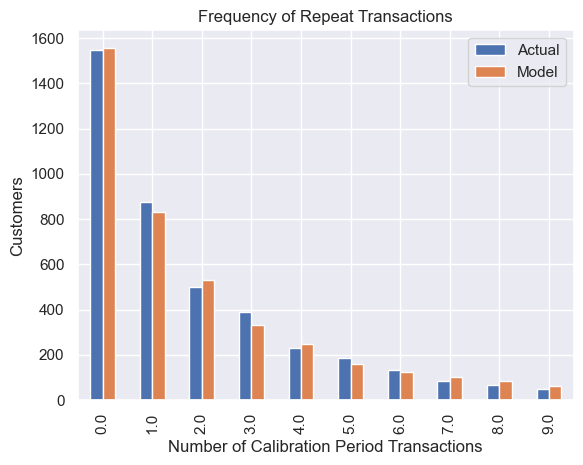

In [67]:
#axis length
max_freq = int(df_rft["frequency"].max())  #quantile(0.95))          
max_T = int(df_rft["T"].max())                         
max_rec = int(df_rft["recency"].max())  
print(max_freq)


# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,  
            max_frequency = 10);

[None, None]

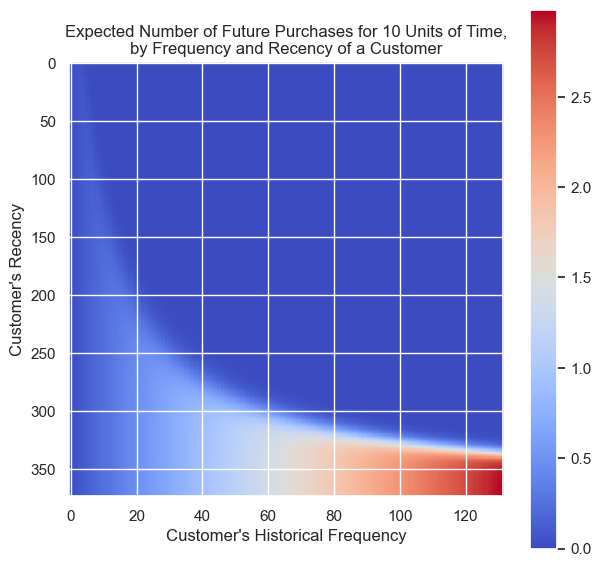

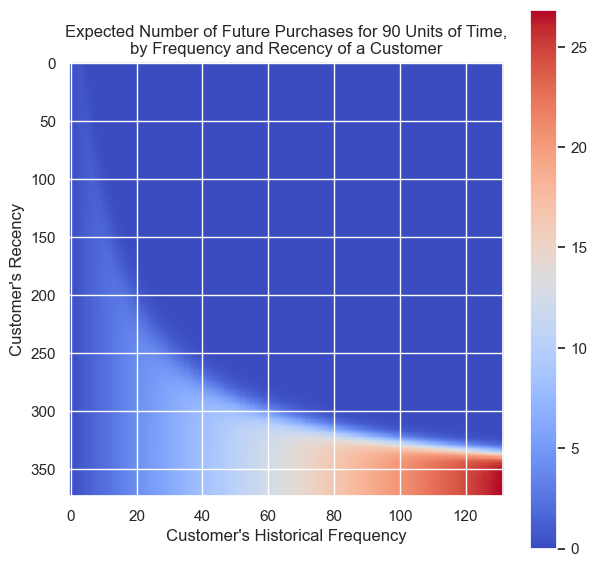

In [69]:
# helper function: plot expected number of future purchases a customer with 
#    frequency f and recency r will make in forecast period

def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7)) 
    plot_frequency_recency_matrix(
            model = bgf,   
            T = t,  
            max_frequency = max_freq,  
            max_recency = max_rec);
            
            
# call plotter function for different forecast periods:
tFC = [10, 90]
[plot_freq_rec(t) for t in tFC]


Let’s randomly pick a customer from the dataset, for instance ID = 12748, and predict her purchases over the next 30 days.

In [70]:
# predict purchases for a selected customer for t days
t = 30
custID = 12748

df_rft_C = df_rft.loc[custID,:]
predC = bgf.predict(    t, 
                        df_rft_C["frequency"], 
                        df_rft_C["recency"], 
                        df_rft_C["T"])
print("customer", custID, ": expected number of purchases within", t, "days =", f'{predC:.1f}')


customer 12748 : expected number of purchases within 30 days = 7.7


In [71]:
df_rft_C

frequency        113.000
recency          373.000
T                373.000
monetary_value   298.361
Name: 12748, dtype: float64

In [79]:
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = bgf.predict(
                    t, 
                    df["frequency"], 
                    df["recency"], 
                    df["T"])
                    
                    
# call helper function: predict each customer's purchases over multiple time periods
t_FC = [10, 30, 60, 90]
[predict_purch(df_rft, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rft

predicted number of purchases for each customer over next t days:


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
CustomerID,,,,,,,,
12346,0.0,0.0,325.0,0.0,0.0,0.1,0.1,0.2
12347,6.0,365.0,367.0,599.7,0.2,0.5,0.9,1.4
12348,3.0,283.0,358.0,301.5,0.1,0.3,0.5,0.8
12349,0.0,0.0,18.0,0.0,0.1,0.3,0.6,0.9
12350,0.0,0.0,310.0,0.0,0.0,0.1,0.1,0.2
...,...,...,...,...,...,...,...,...
18280,0.0,0.0,277.0,0.0,0.0,0.1,0.1,0.2
18281,0.0,0.0,180.0,0.0,0.0,0.1,0.2,0.3
18282,1.0,119.0,126.0,77.8,0.1,0.3,0.6,0.8


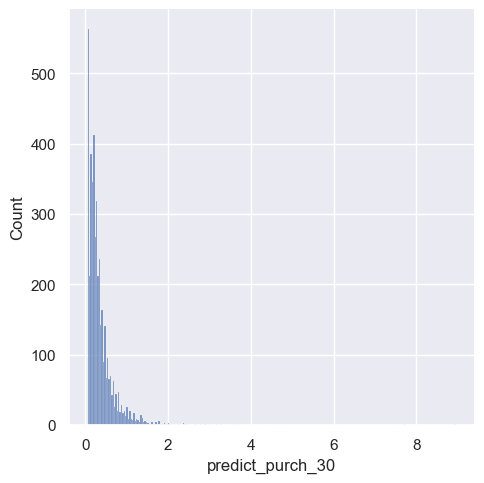

In [80]:
sns.displot(df_rft['predict_purch_30'])

In [81]:
# top 10 customers over next 30 days
print("top 10 customers, by their predicted purchases over next 30 days")
df_rft.sort_values(by="predict_purch_30", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 30 days


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
CustomerID,,,,,,,,
14911,131.0,372.0,373.0,"1,093.7",3.0,8.9,17.9,26.8
12748,113.0,373.0,373.0,298.4,2.6,7.7,15.5,23.2
17841,111.0,372.0,373.0,364.5,2.5,7.6,15.2,22.8
15311,89.0,373.0,373.0,677.7,2.0,6.1,12.2,18.3
14606,88.0,372.0,373.0,135.9,2.0,6.0,12.1,18.1
12971,70.0,369.0,372.0,159.2,1.6,4.8,9.6,14.5
13089,65.0,367.0,369.0,893.7,1.5,4.5,9.0,13.5
14527,53.0,367.0,369.0,155.0,1.2,3.7,7.4,11.1
13798,52.0,371.0,372.0,706.7,1.2,3.6,7.2,10.8


The Lifetimes method probability_of_n_purchases_up_to_time computes the average number of transactions per customer within a period of time.



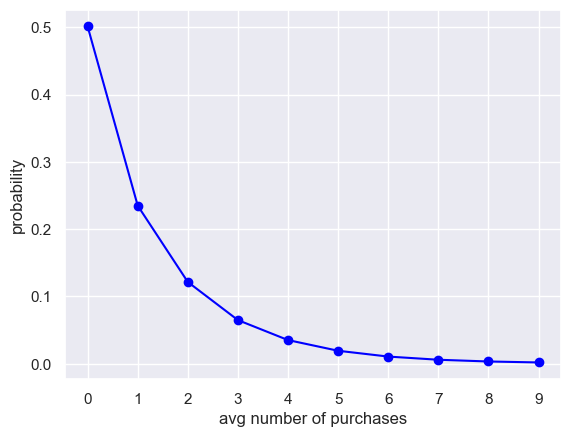

In [82]:
# helper function: probability of n repeat purchases within t days
def prob_purch(t, n):
    p = bgf.probability_of_n_purchases_up_to_time(t, n)
    return p
    
    
    
  # call helper function: probability of n repeat purchases within t days
t = 90                  # forecast period, days
purch = range(0,10,1)   # number of repeat purchases 
probs = [prob_purch(t,n) for n in purch]

dict_probs = dict(zip(purch, probs))
#_ = [print(k,":",f'{v:.2f}') for k,v in dict_probs.items()]

plt.plot(purch, probs, '-o', color='blue')
plt.xlabel("avg number of purchases")
plt.ylabel("probability")
plt.xticks(purch)
plt.show()

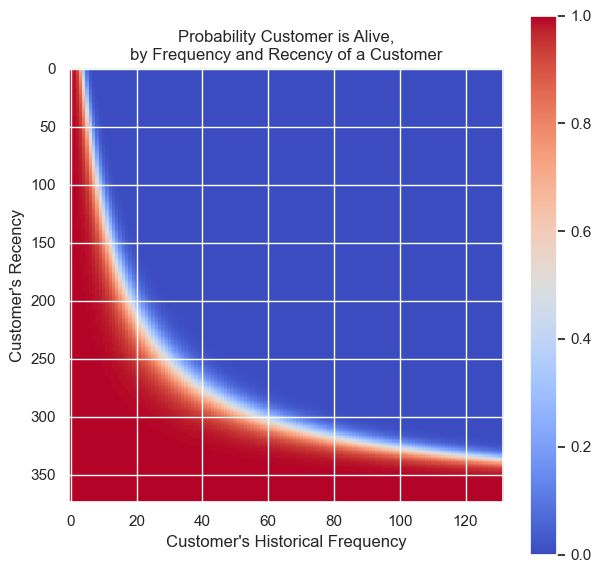

In [83]:
# probability that a customer has not churned (= is alive), based on 
# customer's specific recency r and frequency f
fig = plt.figure(figsize=(7, 7)) 
plot_probability_alive_matrix(
            model = bgf,  
            max_frequency = max_freq,  
            max_recency = max_rec);

Customer with high recency or frequency show high chance of being alive.

The function conditional_probability_alive computes the survival probability for every customer. We insert the array as a new column into the dataframe.



In [84]:
# probability that a customer is alive for each customer in dataframe
prob_alive = bgf.conditional_probability_alive(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"])

df_rft["prob_alive"] = prob_alive
pd.options.display.float_format = '{:,.2f}'.format
df_rft.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
count,"4,339.00","4,339.00","4,339.00","4,339.00","4,339.00","4,339.00","4,339.00","4,339.00","4,339.00"
mean,2.86,130.74,222.78,306.95,0.12,0.36,0.72,1.08,1.00
std,5.95,132.21,117.88,"2,612.45",0.14,0.42,0.85,1.27,0.01
min,0.00,0.00,0.00,0.00,0.02,0.06,0.11,0.17,0.75
25%,0.00,0.00,112.00,0.00,0.05,0.15,0.30,0.45,1.00
50%,1.00,93.00,248.00,176.94,0.09,0.26,0.51,0.77,1.00
75%,3.00,252.00,326.00,360.16,0.14,0.42,0.85,1.27,1.00
max,131.00,373.00,373.00,"168,469.60",2.98,8.95,17.90,26.84,1.00


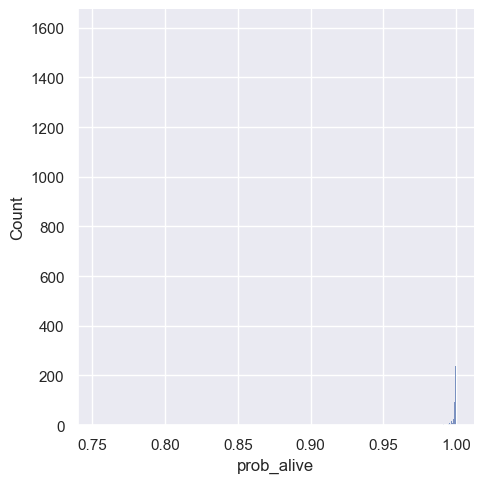

In [86]:
sns.displot(df_rft['prob_alive'])

In [87]:
df_rft[df_rft['prob_alive']<0.9]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
CustomerID,,,,,,,,,
13093,6.00,98.00,373.00,"1,172.18",0.13,0.39,0.79,1.18,0.85
15107,5.00,61.00,372.00,40.70,0.10,0.30,0.60,0.89,0.75
15235,9.00,156.00,373.00,240.89,0.20,0.59,1.18,1.77,0.89
16725,5.00,69.00,371.00,131.77,0.11,0.32,0.65,0.97,0.81


customer 15107 : probability of being alive over time
customer 15107 's probability of being alive, development over time


count   398.00
mean      0.94
std       0.09
min       0.69
25%       0.90
50%       0.98
75%       1.00
max       1.00
dtype: float64

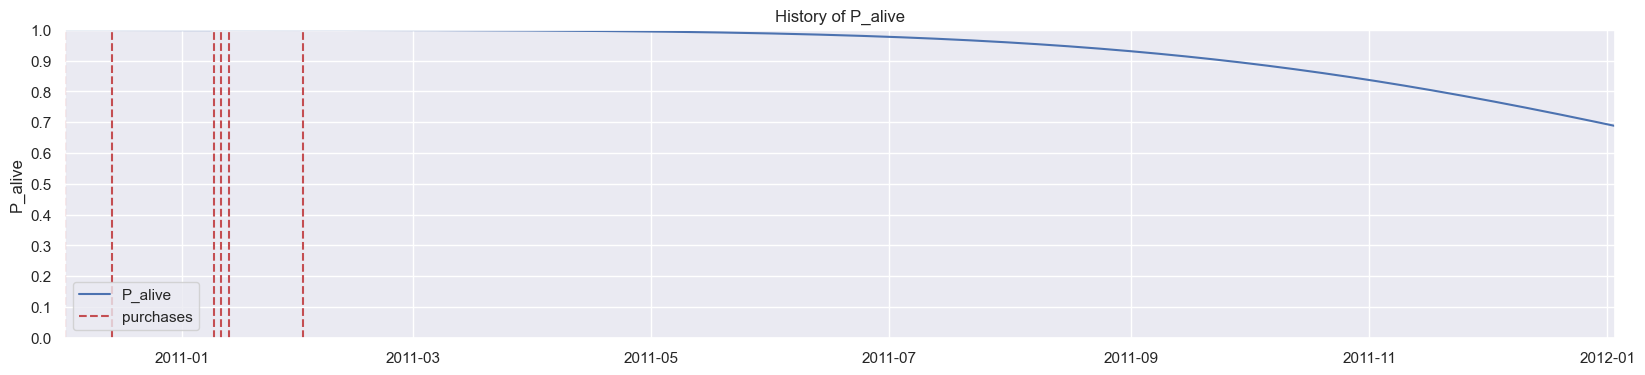

In [89]:
# select a customer

custID = 15107

df1C = df1[df1["CustomerID"] == custID]
df1C.describe()

span_days = 397

# history of the selected customer: probability over time of being alive
fig = plt.figure(figsize=(20,4))
print("customer",custID,": probability of being alive over time")
plot_history_alive(
                    model = bgf, 
                    t = span_days, 
                    transactions = df1C, 
                    datetime_col = "InvoiceDate");
                    
                    
               
 # selected customer's probability of being alive - development over time
path_alive = calculate_alive_path(
            model = bgf, 
            t = span_days, 
            transactions = df1C, 
            datetime_col = "InvoiceDate");
print("customer",custID,"'s probability of being alive, development over time")
path_alive.explode().astype(np.float64).describe()

The BG/NBD model enables us to predict both the number of transactions and the churn risk (conversely, the probability of being alive) for each customer.



The GG model rests on the assumptions that

* customers differ in their average transaction values: for instance, some big spenders may have a propensity to spend twice as much per transaction as others

* the average monetary transaction value of an individual customer is time-invariant within the analytical horizon; the values of the customer’s transactions vary around the mean while the mean itself remains stable over time

The time-invariant average transaction value is the random variable Z we want to pin down.

In 1994, Schmittlein and Peterson proposed that the transaction values follow a normal distribution. But the normal distribution extends to negative infinity and is symmetric around its mean — whereas real-world frequency curves of spendings are non-negative and right-skewed, often distinctively so. Fader/Hardie suggested the Gamma distribution as a more appropriate alternative to mirror a customer’s average transaction value. They define its scale parameter as a Gamma random variable of its own, therefore the label Gamma-Gamma model. (gamma_gamma.DVI (brucehardie.com))

Using Bayes’ theorem, they derive the conditional expectation of a customer’s mean transaction value. The more transactions have been observed, the less weight the model puts on the prior distribution and the more on the customer’s observed mean.

The GG model only works for positive monetary values. Thus, we exclude the few transactions with a unit price of zero.

In [90]:
# select customers with monetary value > 0
df_rftv = df_rft[df_rft["monetary_value"] > 0]
pd.options.display.float_format = '{:,.2f}'.format
df_rftv.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
count,"2,790.00","2,790.00","2,790.00","2,790.00","2,790.00","2,790.00","2,790.00","2,790.00","2,790.00"
mean,4.45,203.33,260.12,477.36,0.16,0.48,0.95,1.43,1.00
std,6.93,111.46,101.48,"3,245.62",0.16,0.49,0.97,1.46,0.01
min,1.00,1.00,9.00,1.00,0.04,0.12,0.24,0.37,0.75
25%,1.00,106.00,197.25,187.25,0.07,0.22,0.45,0.67,1.00
50%,3.00,211.00,284.00,309.47,0.12,0.36,0.71,1.07,1.00
75%,5.00,301.75,358.00,458.37,0.18,0.55,1.11,1.66,1.00
max,131.00,373.00,373.00,"168,469.60",2.98,8.95,17.90,26.84,1.00


In [91]:
corr_matrix = df_rftv[["monetary_value", "frequency"]].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)

Pearson correlation: 0.016


The GG model also requires that the frequency of purchases be independent from their monetary value. The correlation matrix confirms that the Pearson’s correlation coefficient amounts to a modest 0.016 in our example, low enough that we will proceed.



In [93]:
# fitting the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef = 1e-06)
ggf.fit(
        frequency = df_rftv["frequency"],
        monetary_value = df_rftv["monetary_value"],  
        weights = None,   
        verbose = True,  
        tol = 1e-06,  
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17005D+01    |proj g|=  1.09515D+00

At iterate    1    f=  9.93166D+00    |proj g|=  1.00655D+00

At iterate    2    f=  7.05742D+00    |proj g|=  1.24277D-01

At iterate    3    f=  7.04957D+00    |proj g|=  2.41544D-01

At iterate    4    f=  7.02749D+00    |proj g|=  2.51495D-01

At iterate    5    f=  6.97534D+00    |proj g|=  1.05975D-01

At iterate    6    f=  6.96856D+00    |proj g|=  5.51794D-02

At iterate    7    f=  6.95623D+00    |proj g|=  1.45048D-01

At iterate    8    f=  6.92807D+00    |proj g|=  3.10147D-01

At iterate    9    f=  6.91121D+00    |proj g|=  2.51458D-01

At iterate   10    f=  6.89181D+00    |proj g|=  5.23521D-02

At iterate   11    f=  6.89101D+00    |proj g|=  5.69101D-03

At iterate   12    f=  6.89098D+00    |proj g|=  6.19371D-04

At iterate   13    f=  6.8

,coef,se(coef),lower 95% bound,upper 95% bound
p,4.176,0.186,3.811,4.541
q,2.415,0.070,2.279,2.552
v,149.890,8.304,133.614,166.166


conditional_expected_average_profit

In [94]:
# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        df_rftv["frequency"],
        df_rftv["monetary_value"])

df_rftv["exp_avg_rev"] = exp_avg_rev
df_rftv["avg_rev"] = df_rftv["monetary_value"]
df_rftv["error_rev"] = df_rftv["exp_avg_rev"] - df_rftv["avg_rev"]

mape = mean_absolute_percentage_error(exp_avg_rev, df_rftv["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rftv.head()

MAPE of predicted revenues: 0.12


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
CustomerID,,,,,,,,,,,,
12347,6.000,365.000,367.000,599.702,0.157,0.470,0.939,1.409,1.000,591.283,599.702,-8.418
12348,3.000,283.000,358.000,301.480,0.090,0.269,0.537,0.806,0.999,315.770,301.480,14.290
12352,6.000,260.000,296.000,368.257,0.187,0.561,1.122,1.683,1.000,372.213,368.257,3.956
12356,2.000,303.000,325.000,269.905,0.072,0.215,0.430,0.645,0.999,294.879,269.905,24.974
12358,1.000,149.000,150.000,683.200,0.083,0.250,0.500,0.750,0.999,622.209,683.200,-60.991


Similarly, a customer’s “lifetime” denotes the time from her first transaction to her unknown future churn date, when she will turn away from our business. For practical purposes, the “lifetime” horizon should be limited to a user-defined time period, for instance the next 12 months I set as a hyperparameter in line 3, below.


In [95]:
# compute customer lifetime value
DISCOUNT_a = 0.06                # annual discount rate
LIFE = 12                        # lifetime expected for the customers in months

discount_m = (1 + DISCOUNT_a)**(1/12) - 1     # monthly discount rate

clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,  
        frequency = df_rftv["frequency"],  
        recency = df_rftv["recency"],  
        T = df_rftv["T"],  
        monetary_value = df_rftv["monetary_value"],  
        time = LIFE,    
        freq = "D",                          
        discount_rate = discount_m)

df_rftv.insert(0, "CLV", clv)             # expected customer lifetime values
df_rftv.describe().T

,count,mean,std,min,25%,50%,75%,max
CLV,"2,790.000","2,847.318","10,287.967",156.704,757.687,"1,359.021","2,543.874","292,608.151"
frequency,"2,790.000",4.454,6.930,1.000,1.000,3.000,5.000,131.000
recency,"2,790.000",203.329,111.460,1.000,106.000,211.000,301.750,373.000
T,"2,790.000",260.121,101.480,9.000,197.250,284.000,358.000,373.000
monetary_value,"2,790.000",477.361,"3,245.622",1.000,187.254,309.473,458.371,"168,469.600"
predict_purch_10,"2,790.000",0.159,0.162,0.041,0.075,0.119,0.185,2.983
predict_purch_30,"2,790.000",0.476,0.486,0.122,0.224,0.356,0.554,8.949
predict_purch_60,"2,790.000",0.952,0.973,0.244,0.448,0.711,1.107,17.896
predict_purch_90,"2,790.000",1.428,1.459,0.365,0.672,1.067,1.660,26.843
prob_alive,"2,790.000",0.998,0.007,0.752,0.999,0.999,1.000,1.000


In [102]:
df_rftv.sort_values(by = ['CLV'],ascending=False)

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
CustomerID,,,,,,,,,,,,,
16446,"292,608.151",1.000,205.000,205.000,"168,469.600",0.067,0.200,0.400,0.600,0.999,"125,936.553","168,469.600","-42,533.047"
14646,"233,600.492",44.000,353.000,354.000,"6,366.706",1.060,3.180,6.359,9.537,1.000,"6,321.420","6,366.706",-45.286
18102,"190,659.802",25.000,367.000,367.000,"9,349.477",0.592,1.777,3.554,5.331,1.000,"9,230.337","9,349.477",-119.140
17450,"156,943.156",26.000,359.000,367.000,"7,404.690",0.615,1.846,3.692,5.537,1.000,"7,315.099","7,404.690",-89.591
14096,"137,877.467",16.000,97.000,101.000,"4,071.434",0.990,2.970,5.939,8.908,1.000,"3,996.153","4,071.434",-75.281
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12755,182.815,1.000,85.000,365.000,17.550,0.042,0.126,0.252,0.377,0.996,125.056,17.550,107.506
14865,177.794,1.000,365.000,372.000,15.000,0.041,0.124,0.248,0.373,0.999,123.151,15.000,108.151
17194,176.638,1.000,87.000,360.000,10.000,0.042,0.127,0.254,0.382,0.996,119.417,10.000,109.417


The mean CLV across all customers amounts to £ 2,847.

